In [1]:
import numpy as np
np.random.seed(42)

#Data
from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#Measures
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score

from sklearn.mixture import GaussianMixture
from scipy.stats import wasserstein_distance, norm, entropy, skew

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import simps
import matplotlib
font = {'family' : 'Times New Roman',
        'size'   : 14}

matplotlib.rc('font', **font)

In [2]:
X, y = make_classification(n_samples=5000,
                           n_features=8,
                           class_sep=1,
                           n_informative=4,
                           n_classes=2,
                           n_clusters_per_class=3,
                           random_state=42)

In [3]:
kl_distances = []
wasserstein_distances = []

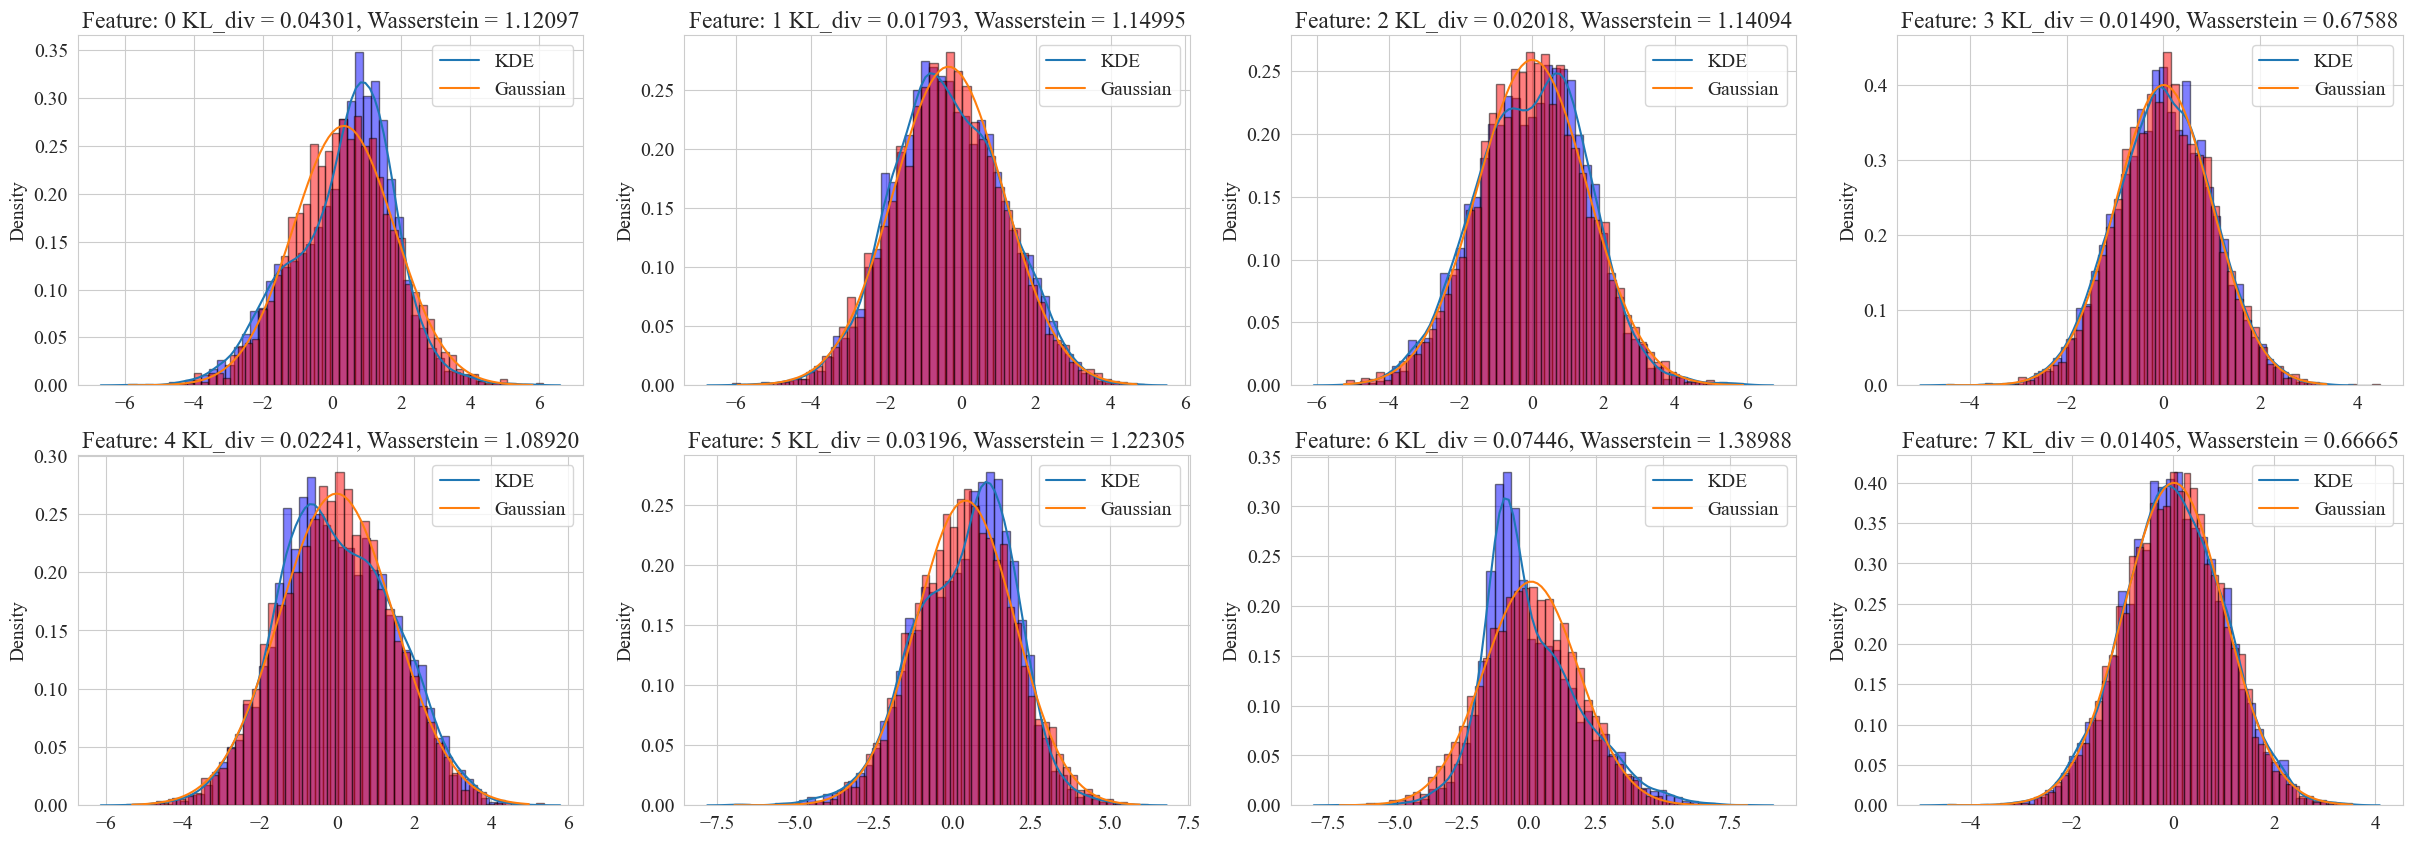

In [4]:
plt.figure(figsize=(30, 10))
for i in range(X.shape[1]):
    plt.subplot(2, 4,i+1)

    sample_data = X[:,i]
    # Reshape the data to a column vector
    #data = sample_data.reshape(-1, 1)
    data = sample_data
    # Plot the histogram of the data
    plt.hist(sample_data, bins=50, density=True, alpha=0.5, color='blue', edgecolor='black')
    # Fit a kernel density estimate (KDE) to the data
    kde = sns.kdeplot(data, gridsize = 100, label='KDE')
    # Fit a Gaussian distribution to the data
    mu, std = norm.fit(data)
    gaussian = norm(mu, std)
    x = np.linspace(min(data), max(data), 100)
    plt.plot(x, gaussian.pdf(x), label='Gaussian')
    gaussian_data=np.random.normal(mu, std, len(data))
    plt.hist(gaussian_data, bins=50, density=True, alpha=0.5, color='red', edgecolor='black')
    # Compute KL divergence
    kde_values = kde.get_lines()[0].get_ydata()
    gaussian_values = gaussian.pdf(x)

    #Normalize the distributions
    kde_values /= simps(kde_values, dx=x[1] - x[0])
    gaussian_values /= simps(gaussian_values, dx=x[1] - x[0])

    # Compute KL divergence
    kl_divergence = entropy(kde_values, gaussian_values)
    wasserstein = wasserstein_distance(kde_values, gaussian_data)
    kl_distances.append(kl_divergence)
    wasserstein_distances.append(wasserstein)
    plt.title('Feature: %.0f KL_div = %.5f, Wasserstein = %.5f' % (i, kl_divergence,wasserstein))
    plt.legend()

In [5]:
print(f'KL: {np.mean(kl_distances)} Wassertein: {np.mean(wasserstein_distances)}')

KL: 0.029862784698231955 Wassertein: 1.0570635684326692


In [6]:
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}
classifier_names = list(classifiers.keys())
measure_steps = [1,2,3,4]
n_steps = len(measure_steps)
metrics = {
    'Accuracy': np.zeros((len(classifiers), n_steps)),
    'Precision': np.zeros((len(classifiers), n_steps)),
    'Recall': np.zeros((len(classifiers), n_steps)),
    'F1 Score': np.zeros((len(classifiers), n_steps))
}

In [7]:
measure_values = []
for i, step in enumerate(measure_steps):


    X, y = make_classification(n_samples=5000,
                           n_features=12,
                           class_sep=1,
                           n_informative=8,
                           n_classes=2,
                           n_clusters_per_class=step,
                           random_state=42)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    distances = []
    kl_distances = []
    wasserstein_distances = []
    for k in range(X_train.shape[1]):

        sample_data = X_train[:,i]
        data = sample_data
        data = sample_data.reshape(-1, 1)
        # Fit a Gaussian Mixture Model with a single component (a single Gaussian)
        gmm = GaussianMixture(n_components=1)
        gmm.fit(data)

        # Get the mean and standard deviation from the fitted model
        mean = gmm.means_[0][0]
        std_dev = np.sqrt(gmm.covariances_[0][0])
        gaussian_data = np.random.normal(mean, std_dev,len(data))

        #dist = wasserstein_distance(sample_data, gaussian_data)
        dist = wasserstein_distance(sample_data, gaussian_data)
        wasserstein_distances.append(dist)

        '''


        # Fit a kernel density estimate (KDE) to the data
        kde = sns.kdeplot(data, gridsize = 100, label='KDE')
        # Fit a Gaussian distribution to the data
        mu, std = norm.fit(data)
        gaussian = norm(mu, std)
        x = np.linspace(min(data), max(data), 100)
        gaussian_data=np.random.normal(mu, std, len(data))
        # Compute KL divergence
        kde_values = kde.get_lines()[0].get_ydata()
        gaussian_values = gaussian.pdf(x)

        #Normalize the distributions
        kde_values /= simps(kde_values, dx=x[1] - x[0])
        gaussian_values /= simps(gaussian_values, dx=x[1] - x[0])

        # Compute KL divergence
        kl_divergence = entropy(kde_values, gaussian_values)
        wasserstein = wasserstein_distance(sample_data, gaussian_data)
        kl_distances.append(kl_divergence)
        wasserstein_distances.append(wasserstein)
        '''

    measure_values.append(np.mean(wasserstein_distances))

    for j, (classifier_name, classifier) in enumerate(classifiers.items()):

            # Standardize the features (optional but often recommended)
            scaler = StandardScaler()
            train_X_scaled = scaler.fit_transform(X_train)
            test_X_scaled = scaler.transform(X_test)
            # Train the classifier
            classifier.fit(train_X_scaled, y_train)
            # Make predictions on the fixed test set
            predictions = classifier.predict(test_X_scaled)
            # Calculate metrics and store in the metrics dictionary
            metrics['Accuracy'][j, i] = balanced_accuracy_score(y_test, predictions)
            metrics['Precision'][j, i] = precision_score(y_test, predictions, average='weighted')
            metrics['Recall'][j, i] = recall_score(y_test, predictions, average='weighted')
            metrics['F1 Score'][j, i] = f1_score(y_test, predictions, average='weighted')

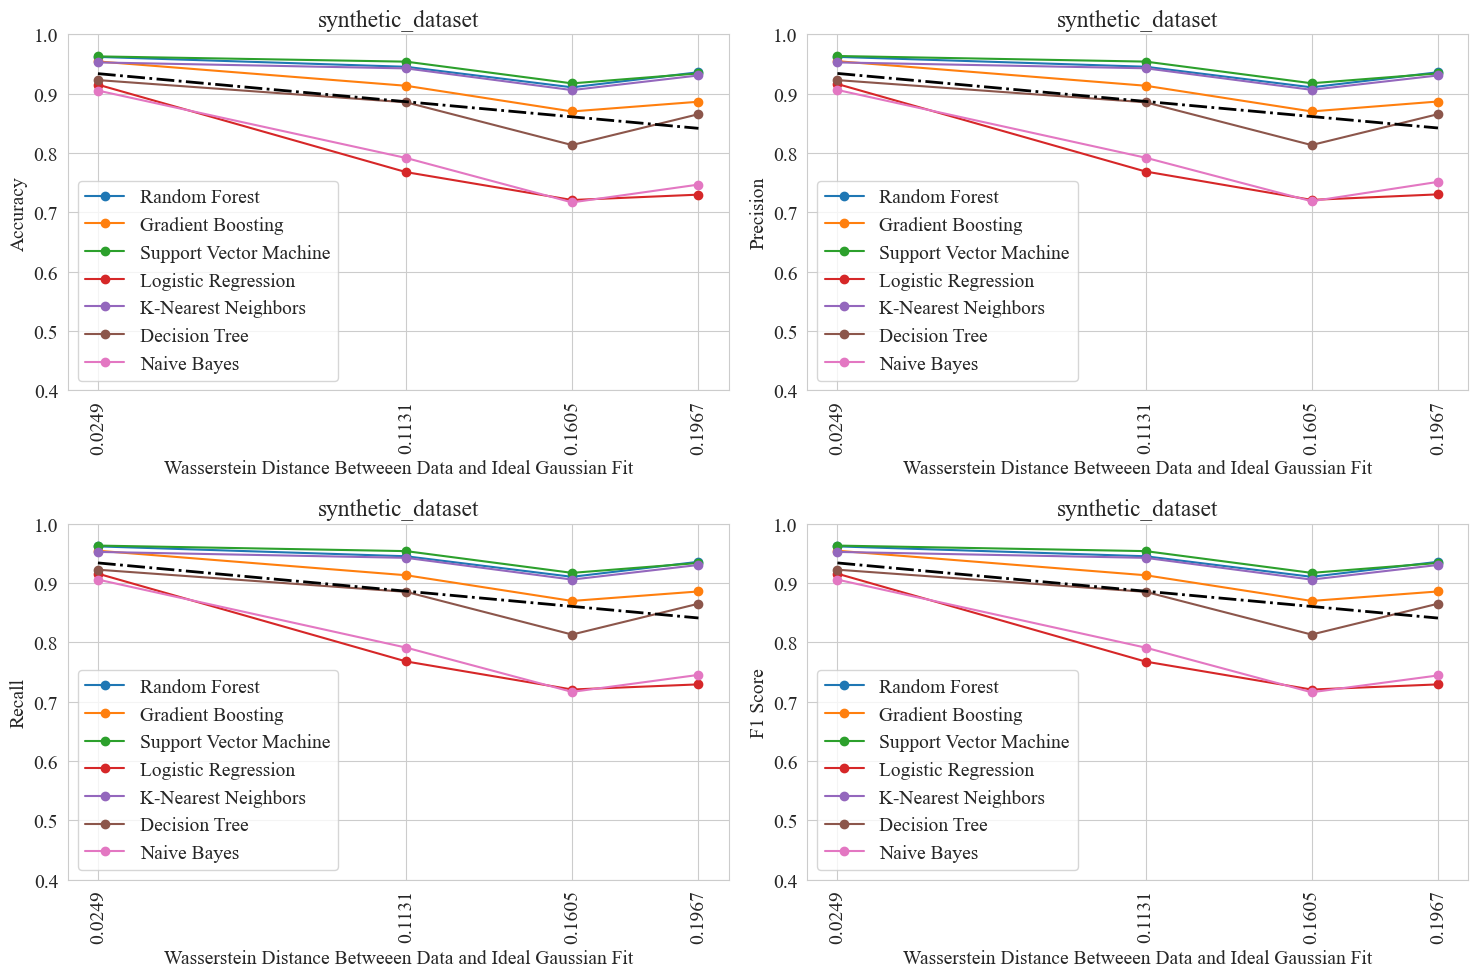

In [8]:
dataset_name = 'synthetic_dataset'

# Plotting
plt.figure(figsize=(15, 10))

for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_values, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=90)

        plt.xlabel('Wasserstein Distance Betweeen Data and Ideal Gaussian Fit')
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_values, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/skeweness_{dataset_name}.svg', format='svg')
plt.show()